In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union
from rich.console import Console
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from flwr_datasets import FederatedDataset
import flwr as fl
from flwr.common import Parameters, FitIns, FitRes, Scalar, ndarrays_to_parameters, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server import ServerConfig

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLIENTS = 10
BATCH_SIZE = 32
from flwr_datasets.partitioner import DirichletPartitioner
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

def load_datasets(partition_id: int):
    """Load and prepare MNIST dataset partitions for a specific client."""
    fds = FederatedDataset(dataset="mnist", partitioners={"train":partitioner})
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

In [ ]:
class Net(nn.Module):
    """CNN model for MNIST classification."""
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*3*3,512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
def train(net, trainloader, epochs:int, ci, c, lr=0.01, verbose=False):
    """Train the network with SCAFFOLD correction."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    initial_params=[param.clone().detach() for param in net.parameters()]

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            # Applying SCAFFOLD correction
            with torch.no_grad():
                for param, grad, ci_i, c_i in zip(net.parameters(), [p.grad for p in net.parameters()], ci, c):
                    grad.add_(ci_i-c_i)

            optimizer.step()
            epoch_loss+=loss.item()
            total+=labels.size(0)
            correct+=(torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss/=len(trainloader.dataset)
        epoch_acc=correct/total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    delta_ci=[]
    with torch.no_grad():
        for param, init_param, ci_i, c_i in zip(net.parameters(), initial_params, ci, c):
            delta=(param-init_param)/(epochs*lr)
            new_ci_i=ci_i-c_i+delta
            delta_ci.append(new_ci_i-ci_i)

    return get_parameters(net), delta_ci

In [ ]:
def test(net, testloader):
    """Evaluate the network on the test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

        # Initializing client control variate (ci)
        self.ci=[torch.zeros_like(param).to(DEVICE) for param in net.parameters()]
        self.param_shapes=[param.shape for param in net.parameters()]

    def get_parameters(self,config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        c=[]
        for i,shape in enumerate(self.param_shapes):
            flat_size=np.prod(shape)
            c_tensor=torch.zeros(shape).to(DEVICE)
            flat_tensor=c_tensor.view(-1)
            for j in range(flat_size):
                key=f"c_{i}_{j}"
                if key in config:
                    flat_tensor[j]=config[key]
            c.append(c_tensor)

        set_parameters(self.net, parameters)
        new_params,delta_ci=train(self.net,self.trainloader,epochs=1,ci=self.ci,c=c)
        # Update client control variate
        for i in range(len(self.ci)):
            self.ci[i]=self.ci[i]+delta_ci[i]

        metrics = {}
        for i,d_ci in enumerate(delta_ci):
            d_flat=d_ci.cpu().flatten()
            metrics[f"delta_ci_{i}_shape"] = "_".join([str(dim) for dim in d_ci.shape])
            metrics[f"delta_ci_{i}_mean"] = float(d_flat.mean())
            metrics[f"delta_ci_{i}_std"] = float(d_flat.std() if d_flat.std() > 0 else 1.0)

            nonzero_indices=torch.nonzero(d_flat).flatten()
            if len(nonzero_indices)>1000:
                _, top_indices=torch.topk(torch.abs(d_flat),k=1000)
                selected_indices=top_indices
            else:
                selected_indices=nonzero_indices

            for j,idx in enumerate(selected_indices):
                metrics[f"delta_ci_{i}_idx_{j}"] = int(idx)
                metrics[f"delta_ci_{i}_val_{j}"] = float(d_flat[idx])
            metrics[f"delta_ci_{i}_count"] = len(selected_indices)

        return new_params, len(self.trainloader.dataset), metrics

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    cid=context.node_id%NUM_CLIENTS
    trainloader,valloader,_=load_datasets(partition_id=cid)
    net = Net().to(DEVICE)
    return FlowerClient(cid, net, trainloader, valloader).to_client()

_, _,global_testloader=load_datasets(partition_id=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class ScaffoldStrategy(FedAvg):
    def __init__(self, *args, **kwargs):
        self.net = Net().to(DEVICE)
        self.c=[torch.zeros_like(param).to(DEVICE) for param in self.net.parameters()]
        self.param_shapes = [param.shape for param in self.net.parameters()]
        self.test_net = Net().to(DEVICE)
        self.global_testloader = kwargs.pop("global_testloader", None)
        self.accuracies = []
        self.losses = []
        self.rounds = []
        super().__init__(*args, **kwargs)

    def configure_fit(self, server_round, parameters, client_manager):
        """Configure the next round of training."""
        config = {}
        for i,c_i in enumerate(self.c):
            flat_c=c_i.cpu().flatten()
            max_values=min(1000,len(flat_c))
            indices=torch.randperm(len(flat_c))[:max_values]

            for j,idx in enumerate(indices):
                config[f"c_{i}_{idx.item()}"] = float(flat_c[idx])

        fit_ins = FitIns(parameters, config)
        clients=client_manager.sample(
            num_clients=self.min_fit_clients,
            min_num_clients=self.min_fit_clients,
        )
        return [(client,fit_ins) for client in clients]

    def aggregate_fit(self, server_round, results, failures):
        """Aggregate model weights and control variates."""
        if not results:
            return None, {}

        weights_results=[(fit_res.num_examples, fit_res.parameters) for _, fit_res in results]
        parameters_aggregated = ndarrays_to_parameters(
            self.aggregate(weights_results)
        )
        for _, fit_res in results:
            for i in range(len(self.c)):
                shape_key = f"delta_ci_{i}_shape"
                count_key = f"delta_ci_{i}_count"
                mean_key = f"delta_ci_{i}_mean"
                std_key = f"delta_ci_{i}_std"

                if all(k in fit_res.metrics for k in [shape_key, count_key, mean_key, std_key]):
                    shape_str = fit_res.metrics[shape_key]
                    shape = tuple(int(dim) for dim in shape_str.split("_"))
                    count = int(fit_res.metrics[count_key])
                    mean_val = fit_res.metrics[mean_key]
                    std_val = fit_res.metrics[std_key]
                    delta_ci = torch.zeros(shape).to(DEVICE)
                    flat_delta = delta_ci.view(-1)

                    for j in range(count):
                        idx_key = f"delta_ci_{i}_idx_{j}"
                        val_key = f"delta_ci_{i}_val_{j}"
                        if idx_key in fit_res.metrics and val_key in fit_res.metrics:
                            idx = int(fit_res.metrics[idx_key])
                            val = fit_res.metrics[val_key]
                            flat_delta[idx] = val

                    weight = fit_res.num_examples / sum(fr.num_examples for _, fr in results)
                    self.c[i] = self.c[i] + weight * delta_ci

        set_parameters(self.test_net, parameters_to_ndarrays(parameters_aggregated))
        loss, accuracy = test(self.test_net, self.global_testloader)

        self.rounds.append(server_round)
        self.accuracies.append(accuracy)
        self.losses.append(loss)
        print(f"Round {server_round} | Global test loss: {loss:.4f} | Global test accuracy: {accuracy:.4f}")
        return parameters_aggregated, {}

    def aggregate(self, results: List[Tuple[int, Parameters]]) -> List[np.ndarray]:
        """Compute weighted average of parameters."""
        total_examples = sum([num_examples for num_examples, _ in results])
        _, first_params = results[0]
        first_params_ndarrays = parameters_to_ndarrays(first_params)
        weighted_params=[np.zeros_like(param) for param in first_params_ndarrays]
        for num_examples, params in results:
            params_ndarrays = parameters_to_ndarrays(params)
            weight = num_examples / total_examples
            for i, param in enumerate(params_ndarrays):
                weighted_params[i] += weight * param

        return weighted_params

    def plot_accuracy_vs_rounds(self):
        """Plot the accuracy vs communication rounds."""
        plt.figure(figsize=(9,3))
        plt.plot(self.rounds, self.accuracies, 'o-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('scaffold_accuracy_vs_rounds.png')
        plt.show()

In [ ]:
global_strategy = None

def server_fn(context: Context) -> ServerAppComponents:
    """Create server instance."""
    global global_strategy
    strategy = ScaffoldStrategy(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        global_testloader=global_testloader,
    )
    global_strategy = strategy

    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.1}}

server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn=client_fn)

In [ ]:
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1774) 2025-04-28 06:19:41.293192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1774) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1774) E0000 00:00:1745821181.326413    1774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1774) E0000 00:00:1745821181.338450    1774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1774) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

Round 1 | Global test loss: 0.0694 | Global test accuracy: 0.2970


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=1773, ip=172.28.0.12, actor_id=111a181783d37fca85e5d36801000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7e23e7d79cd0>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=1773, ip=172.28.0.12, actor_id=111a181783d37fca85e5d36801000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0

Round 2 | Global test loss: 0.0699 | Global test accuracy: 0.3297


(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1773) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025). [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated 7x across cluster]
(ClientAppActor pid=1774) Found the latest cached dataset

Round 3 | Global test loss: 0.0661 | Global test accuracy: 0.4033


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 4 | Global test loss: 0.0750 | Global test accuracy: 0.4193


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1773) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 5 | Global test loss: 0.0775 | Global test accuracy: 0.4432


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1773) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated

Round 6 | Global test loss: 0.0945 | Global test accuracy: 0.4467


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1773) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 7 | Global test loss: 0.0988 | Global test accuracy: 0.6386


(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated 2x across cluster]
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025). [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 8 | Global test loss: 0.0688 | Global test accuracy: 0.6403


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Round 9 | Global test loss: 0.0808 | Global test accuracy: 0.5726


(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated 7x across cluster]
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025). [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1774) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub [repeated 7x across cluster]
(ClientAppActor pid=1774) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025). [repeated 7x across cluster]
(ClientAppActor pid

Round 10 | Global test loss: 0.0918 | Global test accuracy: 0.6844


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 405.34s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.062481467308543925
INFO :      		round 2: 0.013585925843815782
INFO :      		round 3: 0.011173147094625788
INFO :      		round 4: 0.016257142741317853
INFO :      		round 5: 0.025563006061606986
INFO :      		round 6: 0.0239778167466414
INFO :      		round 7: 0.021306653938072198
INFO :      		round 8: 0.008265251019761128
INFO :      		round 9: 0.009770351156992355
INFO :      		round 10: 0.0027289266647961717
INFO :      
(ClientAppActor pid=1773) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1773) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Mon Apr 28 06:20:26 2025).


In [ ]:
def print_summary(self):
    print(f"{'Round':<10}{'Accuracy':<15}")
    print("-"*25)
    for round_num, acc, loss in zip(self.rounds, self.accuracies, self.losses):
        print(f"{round_num:<10}{acc:.4f}{' '*10}")
    print("="*25)
print_summary(global_strategy)

Round     Accuracy       
-------------------------
1         0.2970          
2         0.3297          
3         0.4033          
4         0.4193          
5         0.4432          
6         0.4467          
7         0.6386          
8         0.6403          
9         0.5726          
10        0.6844          


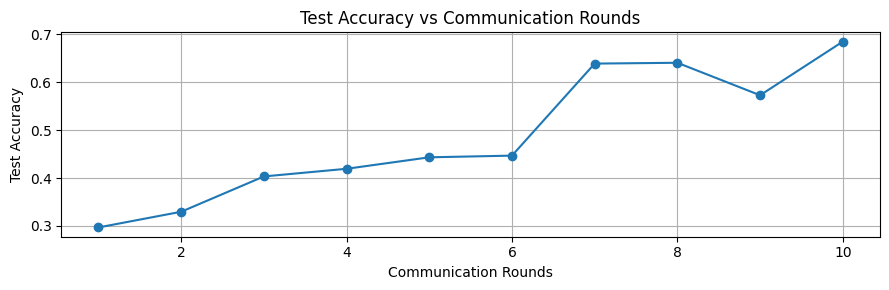

In [ ]:
global_strategy.plot_accuracy_vs_rounds()